In [3]:
import numpy as np
import os
from fine_tune_model import define_classifier_for_classification_for_response
from validation_method import stratified_5_fold_classification, nested_cross_validation_classification, loocv_classification
from utils_simple_prediction import add_task_change_data, load_data_for_classification, add_cgi, add_mddr, set_path, load_task_change_data, save_model_seed
import time
import pandas as pd
set_path()

Current system is Ubuntu


In [8]:
"""

result[model][modality][...]


"""
models = ['Naive Bayes', 'Random Forest', 'Discriminant Analysis(QDA)', 'XGBoost', 'SVM', 'SGDClassifier']# 'KNN', 'MLP',  , 'Discriminant Analysis(LDA)'
modalities = ['fnirs_modality_classification', 'clinical_data_and_fnirs_modality_classification', 'clinical_data_modality_classification']
modalities_to_name = {
    'clinical_data_modality_classification': 'Tier 1', 
    'fnirs_modality_classification': 'Tier 2', 
    'clinical_data_and_fnirs_modality_classification': 'Tier 3'

}
main_fold = 'results/ML_results/simple_prediction_response/'


auc_result = result = {model: {modality: {} for modality in modalities} for model in models}


In [9]:

for model in models:
    for modality in modalities:
        result_pth = main_fold + modality + '/' + model + '.csv'
        df = pd.read_csv(result_pth)
        mean_values = df.mean()
        mean_dict = mean_values.to_dict()
        # print(mean_dict)
        result[model][modality] = mean_dict


nested_flag = 'validation' # 'external'
metrics = ['auc', 'acc', 'sen', 'spe']
name_of_metrics = ['AUC','bAcc', 'Sen', 'Spe']
for i in range(len(modalities)):
    if i == 0:
        print('| ', end = '')
    print(f"| {modalities_to_name[modalities[i]]} | | | ", end='')
print('|')
print("|" + " --- |" * (len(modalities) * len(name_of_metrics) + 1))
print('| ', end = '')
for i in range(len(modalities)):
    for metric in metrics:
        print(f"| {name_of_metrics[metrics.index(metric)]} ", end='')
print('|')

print('| External LOOCV' + '| ' * (len(metrics) * len(modalities) + 1) )


for nested_flag in ['test', 'validation']:
    for model in models:
        print(f"| {model} ", end='')
        for modality in modalities:
            # modality_name = modalities_to_name[modality]
            for metric in metrics:
                val = result[model][modality][nested_flag + '_' + metric]
                print(f"| {val:.3f} ", end='')
        
        print('|')
    print('| Inner Straified 5-fold CV' + '| ' * (len(metrics) * len(modalities) + 1) )


| | Tier 2 | | | | Tier 3 | | | | Tier 1 | | | |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| | AUC | bAcc | Sen | Spe | AUC | bAcc | Sen | Spe | AUC | bAcc | Sen | Spe |
| External LOOCV| | | | | | | | | | | | | 
| Naive Bayes | 0.769 | 0.724 | 0.703 | 0.745 | 0.700 | 0.697 | 0.661 | 0.733 | 0.498 | 0.498 | 0.064 | 0.933 |
| Random Forest | 0.696 | 0.613 | 0.533 | 0.693 | 0.663 | 0.612 | 0.590 | 0.634 | 0.431 | 0.527 | 0.703 | 0.350 |
| Discriminant Analysis(QDA) | 0.800 | 0.704 | 0.838 | 0.570 | 0.425 | 0.460 | 0.341 | 0.578 | 0.502 | 0.500 | 0.295 | 0.706 |
| XGBoost | 0.636 | 0.575 | 0.577 | 0.573 | 0.603 | 0.545 | 0.601 | 0.489 | 0.435 | 0.462 | 0.729 | 0.195 |
| SVM | 0.617 | 0.694 | 0.773 | 0.615 | 0.239 | 0.564 | 0.720 | 0.408 | 0.236 | 0.562 | 0.723 | 0.401 |
| SGDClassifier | 0.657 | 0.633 | 0.691 | 0.576 | 0.235 | 0.463 | 0.663 | 0.264 | 0.156 | 0.457 | 0.753 | 0.160 |
| Inner Straified 5-fold CV| | | | | | | | | | | | | 
| Naive Bayes | 

In [10]:
import json
for model in models:
    for modality in modalities:
        result_pth = main_fold + modality + '/' + model + '_pred.json'
        with open(result_pth, 'r') as json_file:
            data = json.load(json_file)
            auc_result[model][modality] = data

0
1
2
3
4
5


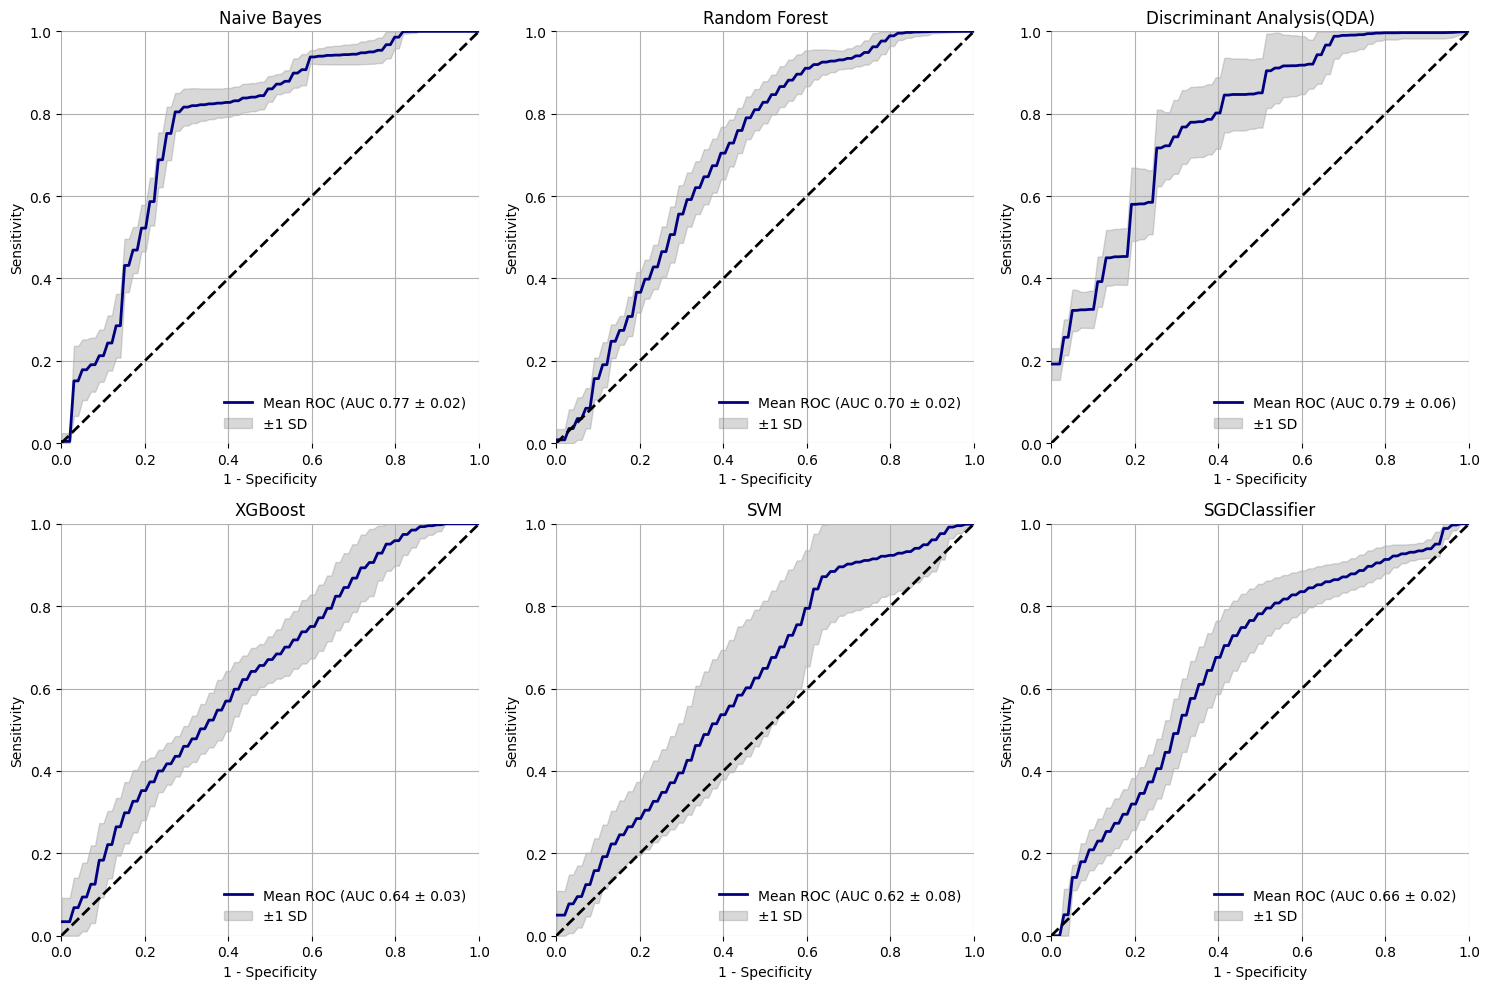

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def plot_avg_auc(fprs, tprs, roc_aucs, title, ax=None):
    mean_fpr = np.linspace(0, 1, 100)

    # Interpolate TPRs at these common FPR levels
    tpr_interpolated = [np.interp(mean_fpr, fprs[i], tprs[i]) for i in range(len(fprs))]
        
    # Calculate the mean and std TPR
    tpr_interpolated = np.array(tpr_interpolated)
    mean_tpr = tpr_interpolated.mean(axis=0)
    std_tpr = tpr_interpolated.std(axis=0)

    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)

    # Compute AUC
    mean_auc = np.mean(roc_aucs)
    std_auc = np.std(roc_aucs)
    
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(mean_fpr, mean_tpr, lw=2, color='#000080', label='Mean ROC (AUC %0.2f ± %0.2f)' % (mean_auc, std_auc))
    ax.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3, label='±1 SD')
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.grid()
    ax.set_xlabel('1 - Specificity')
    ax.set_ylabel('Sensitivity')
    ax.set_title(title)
    ax.legend(loc="lower right", frameon=False)

    for spine in ax.spines.values():
        spine.set_visible(False)

    if ax is None:
        plt.show()
        
        
count = 0
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for count, model in enumerate(models):
    print(count)
    ax = axs[count//3, count%3]
    fprs, tprs, roc_aucs = [], [], []

    for key, value in auc_result[model]['fnirs_modality_classification'].items():
        count+=1
        y_pred = value['y_pred']
        y_true = value['y_pred_prob']
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        fprs.append(fpr)
        tprs.append(tpr)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)

    plot_avg_auc(fprs, tprs, roc_aucs, model, ax)
    plt.tight_layout()


In [57]:
import matplotlib.pyplot as plt
def plot_avg_auc(fprs, tprs, roc_aucs, title):
    mean_fpr = np.linspace(0, 1, 100)

    # Interpolate TPRs at these common FPR levels
    mean_tpr = np.zeros_like(mean_fpr)
    tpr_interpolated = []

    for i in range(len(fprs)):
        tpr_interp = np.interp(mean_fpr, fprs[i], tprs[i])
        tpr_interpolated.append(tpr_interp)
        
        
    # Calculate the mean TPR
    tpr_interpolated = np.array(tpr_interpolated)
    mean_tpr = tpr_interpolated.mean(axis=0)
    std_tpr = tpr_interpolated.std(axis=0)

    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)

    # Compute AUC
    mean_auc = np.mean(roc_aucs) # auc(mean_fpr, mean_tpr)
    std_auc = np.std(roc_aucs)
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, lw=2, color='#000080', label='Mean ROC (AUC %0.2f ± %0.2f)' % (mean_auc, std_auc))
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3, label='±1 SD')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid()
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.legend(loc="lower right", frameon=False)

    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.show()